##### In this section, we will be going through an example run of how the case study should look like. Note that many comments in this notebook are unnncessary for your work as it's there for educational purposes. We begin by import the standard packages.

In [1]:
import numpy as np #not used often here, but comes in handy when doing rough calculations to figure things out
import pandas as  pd #the package that handles our data
import matplotlib.pyplot as plt #remember to add in .pyplot else it won't work

from sklearn.linear_model import LogisticRegression #the model used for this example

##### Now, we import our training and testing data

In [2]:
train_data = pd.read_csv('train_data.csv', index_col=0) #recall that index_col is the variable that we use to tell pandas which column contains the index,
test_data = pd.read_csv('test_data.csv', index_col=0)

In [3]:
#get a preview of the data
train_data.head()

,DEBT,YRS_IN_RESIDENT,AGE,YRS_OF_EMPLOYMENT,DTI,NUM_PREV_APP,OCCUPATION,PROVIDED_SIN,MARRIAGE,INCOME,EDUCATION,CREDIT_PROFILE,APPROVAL_STATUS
0,500.0,1.0,23.0,0.50,0.085,0,1,1,2,8,7,1,0
1,0.0,2.0,33.0,5.50,5.500,12,1001,1,2,11,7,1,1
2,0.0,9.0,19.0,4.50,3.000,0,1,0,1,8,7,1,1
3,100.0,1.0,49.0,0.25,0.250,11,2733,1,1,4,4,1,1
4,300.0,8.0,39.0,0.25,0.085,0,1,1,2,4,4,1,1


##### Let's do a simple visualization for seeing the relationship of INCOME and APPROVAL_STATUS. First, we create a pivot table by getting total approved credit cards for each income bracket in INCOME in train_data. 

In [4]:
income_vs_approval = pd.pivot_table(data=train_data, values='APPROVAL_STATUS', index='INCOME', aggfunc=np.sum) #creates a DataFrame that has the pivot table
#data: the dataframe with all the values for pivoting
#values: the column to sum up
#index: the column for which we sum up values for
#aggfunc: how one wants to 'aggregate' the values, which is np.sum in this case.
income_vs_approval #remember that jupyter notebooks always outputs the last item in the cell, unless you assign it to a variable

,APPROVAL_STATUS
INCOME,
1,5
2,6
3,10
4,12
5,2
6,15
7,13
8,53
9,29


##### Now, we plot the income_vs_approval using matplotlib. Observe from above that our x values are under the INCOME column and our y values are under the APPROVAL_STATUS column. To get the values under INCOME, we use income_vs_approval.index (if one recalls further, we set index='INCOME'). To get the values under APPROVAL_STATUS, we use income_vs_approval.values

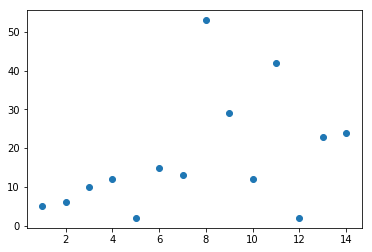

In [5]:
x = np.array(income_vs_approval.index).reshape(-1,1) #coverting it to a numpy array then reshaping it so it'll be 2D shape instead of a 1D shape.
y = income_vs_approval.values #the .values outputs a numpy array of shape (-1,1) already
#the reason we're doing the coversions and reshapings above is due to how sklearn processes data for fitting/learning (it needs a two dimensional shape), as we are going for a line of best fit below.
plt.scatter(x, y) 

##### We see a general trend of approvals going up the higher income bracket you reportedly are. Now, we are going to fit a regression line on it and plot it together. First, we create an regression line using LinearRegression from sci-kit learn.

In [6]:
from sklearn.linear_model import LinearRegression #import linear regression from sklearn to get our regression line
lr = LinearRegression() #creating an instance of LinearRegression
lr.fit(x,y) #fitting our instance of LinearRegression to our pivot table's data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

##### Now, we plot the line with the scatter plot above.

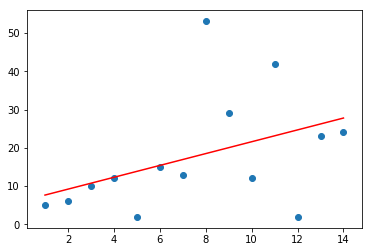

In [7]:
y2 = lr.predict(x) #yes, we are using .predict here, but since we are "predicting" on the training set's x values, it will output the line of best fit's y values at those x points
plt.plot(x,y2, c='r') #c is for changing colors of the plot, 'r' means red. 
plt.scatter(x,y) #putting two plotting functions from matplotlib like this will automatically stack them together

##### We now move on to using logistic regression for automating credit card approvals. Before we build the model, we know that we have some nominal categorical variables. Since we are using logistic regression, we need to one hot encode them. For simplicity, we are going to only one hot encode MARRIAGE


In [8]:
from sklearn.preprocessing import OneHotEncoder #import the OneHotEncoder from sklearn

##### We are going to one hot encode both training and testing set's MARRIAGE . The reason for that is beacuse we are going to fit the model on the "modified" training set (due to encoding of MARRIAGE), so the test set needs the same "modifications".

In [9]:
encoder = OneHotEncoder() #create an instance of OneHotEncoder. Remember, each instance only works for a single feature. You will need more instances for other features
encoded_marriage_train = encoder.fit_transform(train_data['MARRIAGE'].values.reshape(-1,1)) #.values.reshape is for the same reason above, sklearn needs a two dimensional shape
encoded_marriage_test = encoder.transform(test_data['MARRIAGE'].values.reshape(-1,1)) #we use .transform because we already "fitted" the encoder on the training set

##### Before we proceed further, let's take a look at encoded_marriage_train. Observe that the output says 'sparse matrix'. A sparse matrix is a matrix with a lot of zeros. It's used because of its memory efficiency. Since one hot encoding tends to create a very large matrix with a bunch of ones and zeros, sklearn outputs sparse matrices when you use its OneHotEncoder.

In [10]:
encoded_marriage_train

<552x3 sparse matrix of type '<class 'numpy.float64'>'
	with 552 stored elements in Compressed Sparse Row format>

##### Now we are almost ready to train our model. Before we do that, we are going to select a few features to use, of course MARRIAGE is one of them since we already one hot encoded it. Also, we need to turn encoded_marriage_train and encoded_marriage_test into DataFrames to make things more consistent, as sklearn only takes in one 'type' of input for data or labels.

In [11]:
selected_features = ['DEBT', 'AGE', 'YRS_OF_EMPLOYMENT'] #these are the features we're going to use (plus one hot encoded MARRIAGE). We put them in a list to access it later

In [12]:
encoded_marriage_train = pd.DataFrame(encoded_marriage_train.todense()) #the .todense() converts the sparse matrix into a regular matrix (or array), then we put in a DataFrame
encoded_marriage_test = pd.DataFrame(encoded_marriage_test.todense()) #same for the testing set

##### We then make the training and testing sets for our model based on the 4 features. This is done by extracting selected_features from train_data and test_data then concatenating (joining) it with encoded_marriage_train and encoded_marriage_test.

In [13]:
train_data2 = pd.concat([train_data[selected_features], encoded_marriage_train], axis=1) #putting the DataFrames to be concatentated in a list, then set axis=1 since we are joining them by columns
test_data2 = pd.concat([test_data[selected_features], encoded_marriage_test], axis=1) #same for test_data
train_label = train_data.iloc[:,-1] #recall that this is the training data from .csv, we are trying to get the labels which is the last column (hence why -1 is used)
test_label = test_data.iloc[:,-1] #same for testing data.

##### We are finally ready to train and test our model.

In [14]:
lg = LogisticRegression() #first, we create an instance of LogisiticRegression 
lg.fit(train_data2, train_label) #now we train our model, using the prepped data
pred = lg.predict(test_data2) #this gives all the predictions of our model in the testing set

##### Let's import some performance measures to see how our model performs

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix #the imported functions are self explanatory

In [16]:
print('Accuracy: ', accuracy_score(test_label, pred)) #note that all of these functions follow the same format, first arguement is the true labels, second is the predicted labels
print('Recall: ', recall_score(test_label, pred))
print('Precision: ', precision_score(test_label, pred))
print('Confusion Matrix: \n', confusion_matrix(test_label, pred)) #\n in 'Confusion Matrix: \n' means go to next line so that our confusion matrix will look cleaner

Accuracy:  0.6666666666666666
Recall:  0.4745762711864407
Precision:  0.6511627906976745
Confusion Matrix: 
 [[64 15]
 [31 28]]


##### Let's now do some feature selection by adding an extra feature, say NUM_PREV_APP. We just have to copy all the code from above and add in 'NUM_PREV_APP' in selected_features. As a note, if you're going to add a nominal feature, you have to create a new instance of OneHotEncoder, then concatenate it. However, we are adding an ordinal feature this time so there's no need for that

In [17]:
#we skip all the comments and just have the code below
#keep in mind we don't need to import the performance metrics again 
#also, we overwritten encoded_marriage_train with a DataFrame, so there's also no need to copy that
selected_features = ['DEBT', 'AGE', 'YRS_OF_EMPLOYMENT', 'NUM_PREV_APP']
train_data2 = pd.concat([train_data[selected_features], encoded_marriage_train], axis=1) 
test_data2 = pd.concat([test_data[selected_features], encoded_marriage_test], axis=1) 
train_label = train_data.iloc[:,-1] 
test_label = test_data.iloc[:,-1]
lg = LogisticRegression() 
lg.fit(train_data2, train_label)
pred = lg.predict(test_data2) 
print('Accuracy: ', accuracy_score(test_label, pred)) #note that all of these functions follow the same format, first arguement is the true labels, second is the predicted labels
print('Recall: ', recall_score(test_label, pred))
print('Precision: ', precision_score(test_label, pred))
print('Confusion Matrix: \n', confusion_matrix(test_label, pred)) #\n in 'Confusion Matrix: \n' means go to next line so that our confusion matrix will look cleaner

Accuracy:  0.8260869565217391
Recall:  0.6779661016949152
Precision:  0.8888888888888888
Confusion Matrix: 
 [[74  5]
 [19 40]]


##### We see a drastic improvement by adding this feature. We now move on to hyperparameters tuning. 
###### Logistic Regression in sklearn comes default with a L2 regularizer with a coefficient of 1 by default. What L2 regularizer is suppose to do is to prevent overfitting during training. The exact mechanism for how this happens is beyond the scope of these notes. However, this coefficient is a hyperparameter of Logistic Regression, and is used as an example of how to tune hyperparameters using sklearn's GridSearchCV.

In [18]:
from sklearn.model_selection import GridSearchCV

##### First, we put all possible hyperparameters in a Python dictionary. A Python dictionary is just another way of storing data. Essentially, it can be viewed as a list of 'keys' and 'values', where a 'key' has a corresponding 'value'. 
##### LogisticRegression's L2 coefficient is named C in sklearn, so we put 'C' (key). The corresponding 'value' should be all the values we want to test for the best hyperparameter

In [19]:
hyperparams = {'C':[i/100 for i in range(1,100)]} #I start at 1 because C can't take on the value 0. 

##### Now, we create an instance of GridSearchCV to  find the best hyperparamter. First positional argument should be the instance of the model we are trying to optimize. Second positional argument is the dictionary for hyperparamters. The keyword argument scoring is how the gridsearch will be evaluating the different hyperparameters performance. This case, we are using accuracy.

In [20]:
gridsearch = GridSearchCV(lg, hyperparams, scoring='accuracy')

In [21]:
gridsearch.fit(train_data2, train_label) #gridsearch automaticallty makes a validation set from the training data

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48....83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [22]:
gridsearch.best_estimator_ #this gives the best version of the model with its corresponding hyperparameters

LogisticRegression(C=0.62, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Keep in mind that we are only optimizing for accuracy. Depending on the needs for a model, one might be tuning hyperparameters for other performance measures. This concludes the sample run.